In [1]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/triyuliannibasukie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseV

In [2]:
tweets = pd.read_excel('POST 1-31 Aug Twitter Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-08-21 23:59:31+00:00,1561503296430510080,ladyR0SE78,1530861876162306048,NaN,NaN,4,@fractured_J @JanetRally What’s wrong with soc...
1,1,2022-08-21 23:58:38+00:00,1561503072030966016,Platoon19792,1347699807826178048,1.561039e+18,hiswickedrep,23,@hiswickedrep It's not a show about abuse just...
2,2,2022-08-21 23:57:33+00:00,1561502802014138112,CatotheE,1471052048137273088,1.560287e+18,rshainalv,0,@rshainalv Johnny Depp was a victim of abuse. ...
3,3,2022-08-21 23:55:01+00:00,1561502163850886912,AndreaOldfield6,1349517593972011008,NaN,NaN,3,Warner CEO Wants Amber Heard GONE from Aquaman...
4,4,2022-08-21 23:54:50+00:00,1561502117898100992,SmashingBangers,1537862220880695040,1.561210e+18,ethanstarot,1,"@ethanstarot Wait, why did she block me? Is sh..."


In [3]:
df = tweets.filter(['full_text', "created_at"], axis=1)
df2 = df.dropna()
df2.head()

,full_text,created_at
0,@fractured_J @JanetRally What’s wrong with soc...,2022-08-21 23:59:31+00:00
1,@hiswickedrep It's not a show about abuse just...,2022-08-21 23:58:38+00:00
2,@rshainalv Johnny Depp was a victim of abuse. ...,2022-08-21 23:57:33+00:00
3,Warner CEO Wants Amber Heard GONE from Aquaman...,2022-08-21 23:55:01+00:00
4,"@ethanstarot Wait, why did she block me? Is sh...",2022-08-21 23:54:50+00:00


# Data cleaning

In [4]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [5]:
df2.head()

,full_text,created_at,clean_text
0,@fractured_J @JanetRally What’s wrong with soc...,2022-08-21 23:59:31+00:00,"[wrong, society, common, sense, gone, evidence..."
1,@hiswickedrep It's not a show about abuse just...,2022-08-21 23:58:38+00:00,"[show, abuse, abuse, victim, invited, make, sp..."
2,@rshainalv Johnny Depp was a victim of abuse. ...,2022-08-21 23:57:33+00:00,"[victim, abuse, husband, beater]"
3,Warner CEO Wants Amber Heard GONE from Aquaman...,2022-08-21 23:55:01+00:00,"[warner, ceo, wants, gone, aquaman, 2, unhappy..."
4,"@ethanstarot Wait, why did she block me? Is sh...",2022-08-21 23:54:50+00:00,"[wait, block, stan, never, ffs]"


In [6]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
0,@fractured_J @JanetRally What’s wrong with soc...,2022-08-21 23:59:31+00:00,"[society, sense, evidence, abuser, hand, revie..."
1,@hiswickedrep It's not a show about abuse just...,2022-08-21 23:58:38+00:00,"[abuse, abuse, victim, appearance, abuse, defi..."
2,@rshainalv Johnny Depp was a victim of abuse. ...,2022-08-21 23:57:33+00:00,"[victim, abuse, husband, beater]"
3,Warner CEO Wants Amber Heard GONE from Aquaman...,2022-08-21 23:55:01+00:00,"[aquaman, unhappy, delet, fire, mera, look, ab..."
4,"@ethanstarot Wait, why did she block me? Is sh...",2022-08-21 23:54:50+00:00,[block]


In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


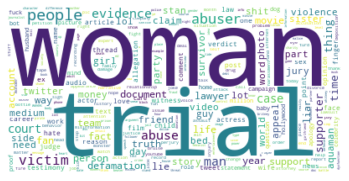

In [8]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

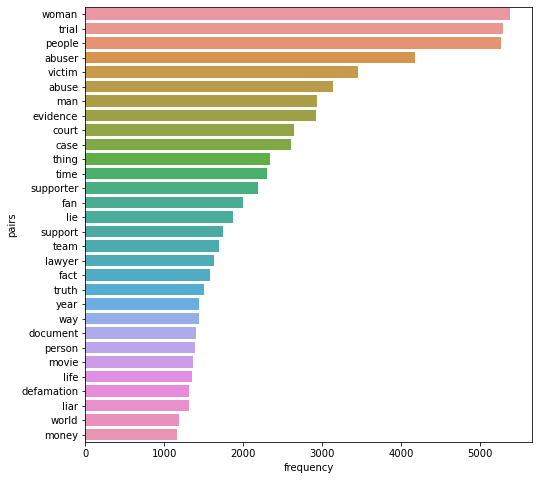

In [9]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [10]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['society', 'sense', 'evidence', 'abuser', 'hand', 'review', 'evidence'], ['abuse', 'abuse', 'victim', 'appearance', 'abuse', 'define', 'victim', 'life', 'career', 'dream'], ['victim', 'abuse', 'husband', 'beater']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'abuser'), (1, 'evidence'), (2, 'hand'), (3, 'review'), (4, 'sense'), (5, 'society'), (6, 'abuse'), (7, 'appearance'), (8, 'career'), (9, 'define'), (10, 'dream'), (11, 'life'), (12, 'victim'), (13, 'beater'), (14, 'husband'), (15, 'aquaman'), (16, 'delet'), (17, 'fire'), (18, 'look'), (19, 'mera'), (20, 'unhappy'), (21, 'block'), (22, 'action'), (23, 'fan'), (24, 'other'), (25, 'supporter'), (26, 'footstep'), (27, 'ceremony'), (28, 'hmm'), (29, 'punch'), (30, 'reception'), (31, 'thing'), (32, 'wonder'), (33, 'audio'), (34, 'clip'), (35, 'example'), (36, 'fight'), (37, 'gun'), (38, 'hole'), (39, 'planet'), (40, 'rabbit'), (41, 'reply'), (42, 'engineer'), (43, 'party'), (44, 'sex'), (45, 'movie'), (46, 'accident'), (47, 'footage'), (48, 'injury'), (49, 'verdict')]

Total Vocabulary Size: 6747


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [13]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [14]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.41839692550310426
Perplexity Score:  -6.978453383717878

topic number:  3
Coherence Score:  0.4186220973368468
Perplexity Score:  -7.0401296356022325

topic number:  4
Coherence Score:  0.3600457897812469
Perplexity Score:  -7.118100694805352

topic number:  5
Coherence Score:  0.37339783003870003
Perplexity Score:  -7.135523243217847

topic number:  6
Coherence Score:  0.40068973876326
Perplexity Score:  -7.177061031407556

topic number:  7
Coherence Score:  0.3545346195669777
Perplexity Score:  -7.196157376053704

topic number:  8
Coherence Score:  0.34015160210023443
Perplexity Score:  -7.2521882431922515

topic number:  9
Coherence Score:  0.3495578489415043
Perplexity Score:  -7.289643515936973

topic number:  10
Coherence Score:  0.33120566076399516
Perplexity Score:  -7.400065878710158

topic number:  11
Coherence Score:  0.336520493399067
Perplexity Score:  -7.597586501915456

topic number:  12
Coherence Score:  0.3165659044737219
Perplexity

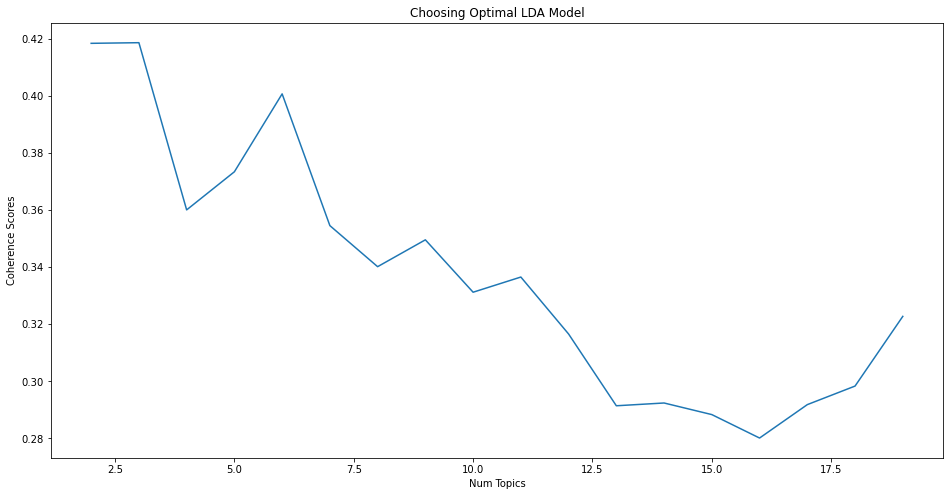

In [15]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [27]:
ntopics_des_name = 3

# We choose 3 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [28]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.060*"trial" + 0.030*"court" + 0.018*"team" + 0.017*"document" + '
  '0.016*"lawyer" + 0.015*"defamation" + 0.014*"movie" + 0.013*"day" + '
  '0.013*"case" + 0.012*"video"'),
 (1,
  '0.026*"fan" + 0.014*"money" + 0.014*"shit" + 0.013*"friend" + 0.013*"time" '
  '+ 0.013*"thing" + 0.011*"account" + 0.011*"people" + 0.011*"girl" + '
  '0.011*"party"'),
 (2,
  '0.048*"woman" + 0.041*"people" + 0.038*"abuser" + 0.031*"victim" + '
  '0.029*"abuse" + 0.026*"man" + 0.017*"lie" + 0.017*"support" + '
  '0.016*"evidence" + 0.015*"supporter"')]


In [29]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [30]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [31]:
df2['Topic'] = topic_num

In [32]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,@fractured_J @JanetRally What’s wrong with soc...,"[society, sense, evidence, abuser, hand, revie...","[2, 0, 1]"
1,@hiswickedrep It's not a show about abuse just...,"[abuse, abuse, victim, appearance, abuse, defi...","[2, 0, 1]"
2,@rshainalv Johnny Depp was a victim of abuse. ...,"[victim, abuse, husband, beater]","[2, 0, 1]"
3,Warner CEO Wants Amber Heard GONE from Aquaman...,"[aquaman, unhappy, delet, fire, mera, look, ab...","[0, 2, 1]"
4,"@ethanstarot Wait, why did she block me? Is sh...",[block],"[1, 0, 2]"


### Model Evaluation

In [33]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.040562004169893
Coherence Score:  0.4100293416639033


## Visualisation

In [34]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111731 -0.295085       1        1  38.711661
0     -0.336218  0.059340       2        1  32.008971
1      0.224486  0.235745       3        1  29.279368, topic_info=          Term         Freq        Total Category  logprob  loglift
73       trial  5214.000000  5214.000000  Default  30.0000  30.0000
54       woman  5076.000000  5076.000000  Default  29.0000  29.0000
0       abuser  3966.000000  3966.000000  Default  28.0000  28.0000
12      victim  3260.000000  3260.000000  Default  27.0000  27.0000
139      court  2624.000000  2624.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
11        life   752.240420  1338.304356   Topic3  -4.6600   0.6522
356        way   750.175778  1395.139150   Topic3  -4.6628   0.6078
111       year   646.286724  1287.520440   Topic3  -4.8118   0.5391
84      people   889.117269  5222.853926   Topic3  -4.4928  -0.5423
25   supporter   577.192081  2171.646874   Topic3  -4.9249  -0.0968

[150 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
6         1  0.999750    abuse
0         1  0.999723   abuser
114       3  0.999176  account
218       2  0.997726    actor
298       3  0.998277  actress
...     ...       ...      ...
217       3  0.982067     work
189       1  0.999731    world
111       1  0.299024     year
111       2  0.198832     year
111       3  0.501740     year

[136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Word Count of Topic Keywords

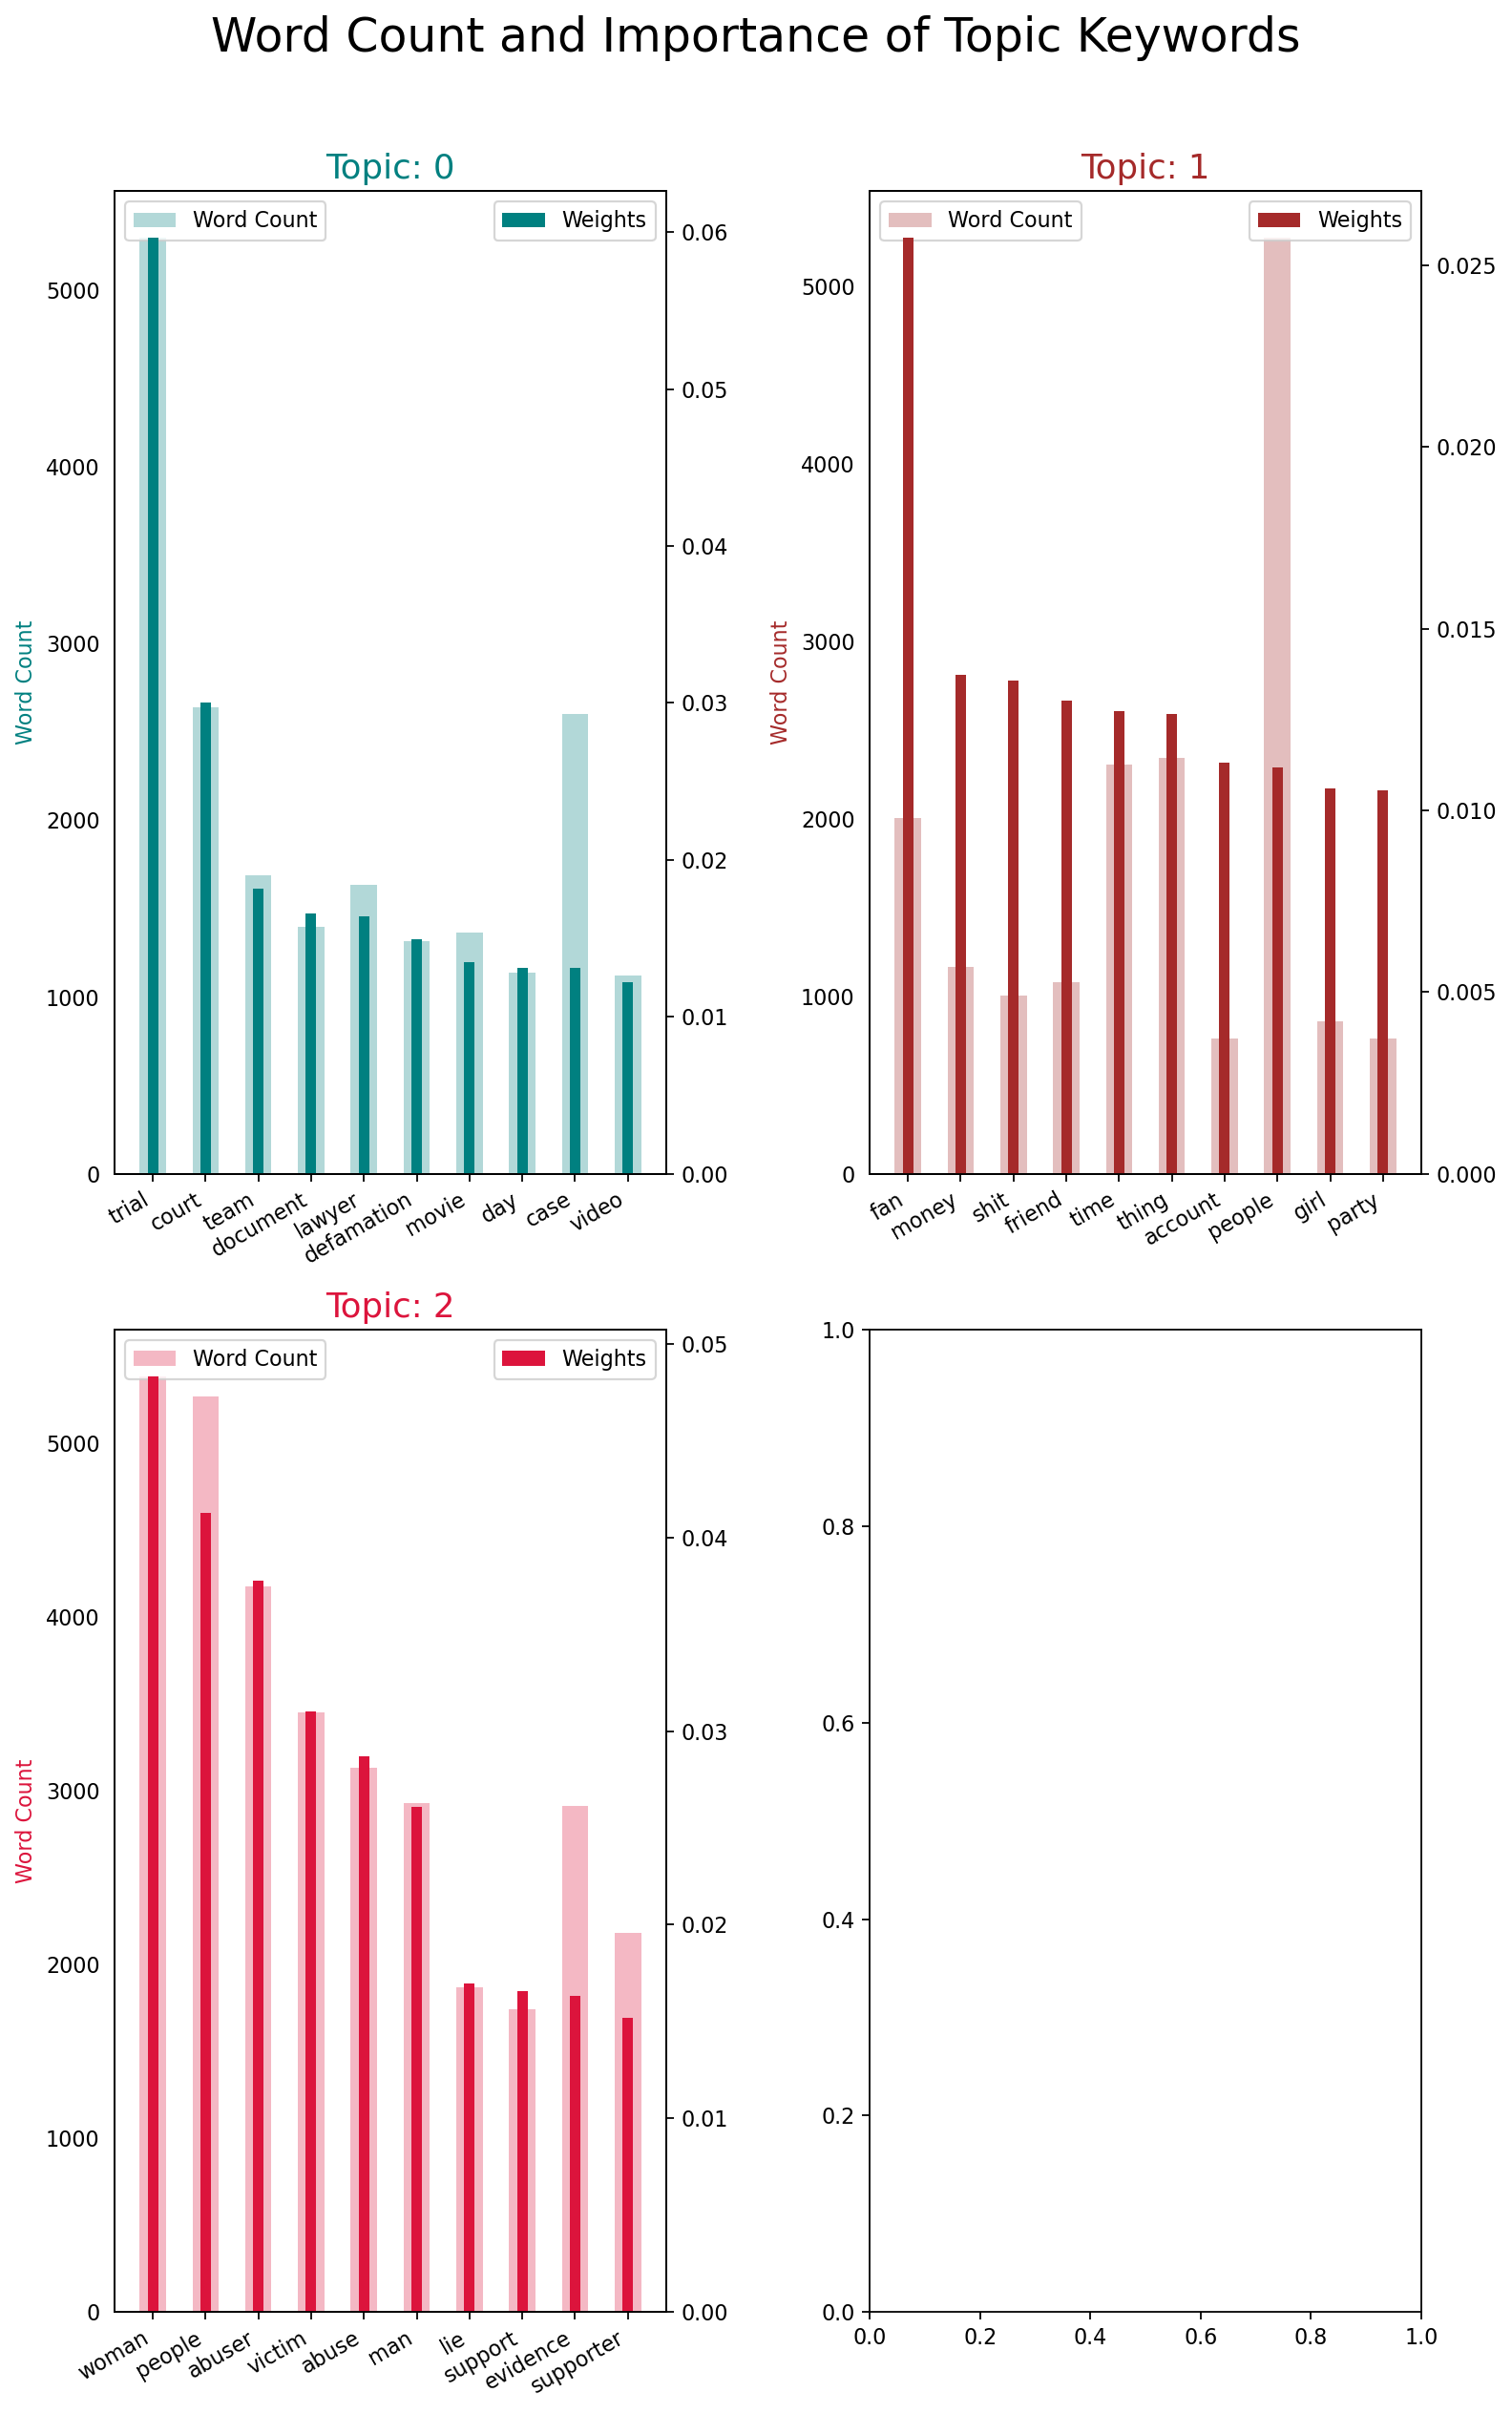

In [36]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
